# Mini-projet: Traitement des signaux de parole #

L’objectif de ce mini-projet est d’implémenter, de manière simplifiée, des modèles utilisés pour traiter les signaux de parole en téléphonie cellulaire.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

import scipy
from scipy.signal import resample, lfilter
from scipy.signal.windows import hann
from scipy.linalg import solve_toeplitz, toeplitz

from math import *

import utils


fs = 8e3  # sampling frequency

## Fenêtrage du signal

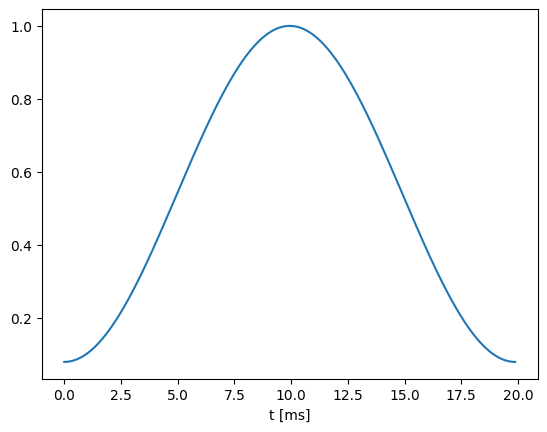

In [3]:
def make_window(L, fs):
    """
    Returns the Hamming window

    Parameters
    ----------

    L: window duration (s)
    fs: sample rate

    Return
    ------
    """

    size = int(L*fs)  # number of elements of the window
    times = np.linspace(0, L, size)
    window = 0.54 - 0.46 * np.cos(2*np.pi/L * times)

    return window

window=make_window(0.02,fs)
utils.plot_signal(window,fs)

D'après le test effectué plus haut on obtient que la fonction `make_window` permet bien de créer la fenêtre de Hamming demandée. Le signal sera rééchantillonné à 8 kHz lors du traitement du fichier audio en dehors de cette fonction. Désormais implantons la fonction `block_decomposition` qui permet de fenêtrer le signal.

In [6]:
def blocks_decomposition(x, w, R=0.5):
    """
    Performs the windowing of the signal

    Parameters
    ----------

    x: numpy array
      single channel signal
    w: numpy array
      window
    R: float (default: 0.5)
      overlapping between subsequent windows
      unité ? %

    Return
    ------

    out: numpy array
      block decomposition of the signal
    """
    
    interval = int(w.size * R)
    # correspondant à la moitié de la taille de la fenêtre si R=0.5

    # signal étendu pour fenêtrer le dernier morceau plus court que la fenêtre
    x_ext = np.pad(x, (0, interval))

    blocks = np.zeros(shape=(x.size // interval, w.size))

    for k in range(blocks.shape[0]):
        blocks[k, :] = x_ext[k * interval: k * interval + w.size] * w
        # utils.plot_signal(blocks[k, :],fs)

    return blocks

Testons le fenêtrage implanté sur un signal constant pour savoir si on obtient le résultat escompté.

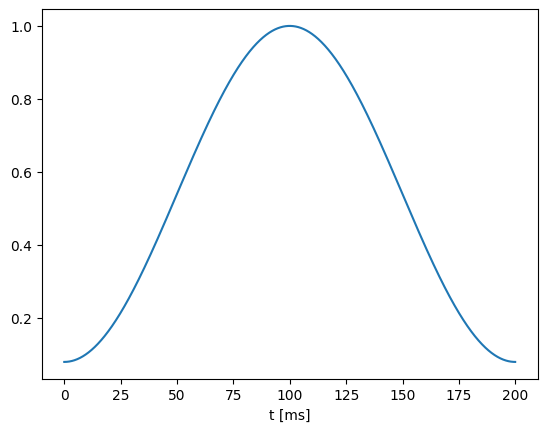

(1600,)


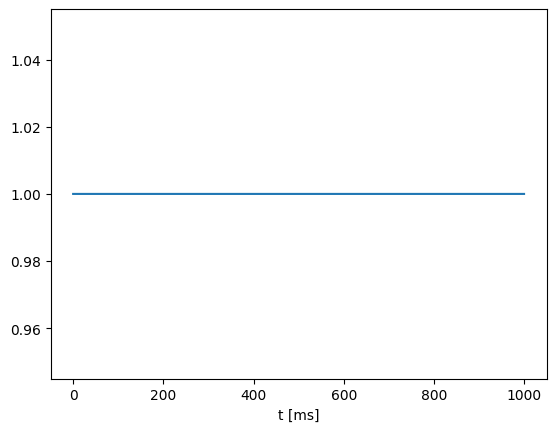

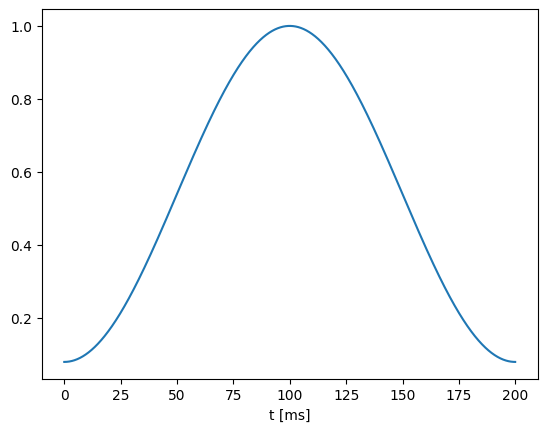

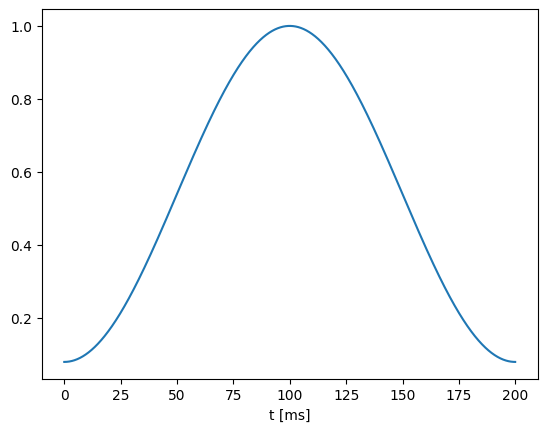

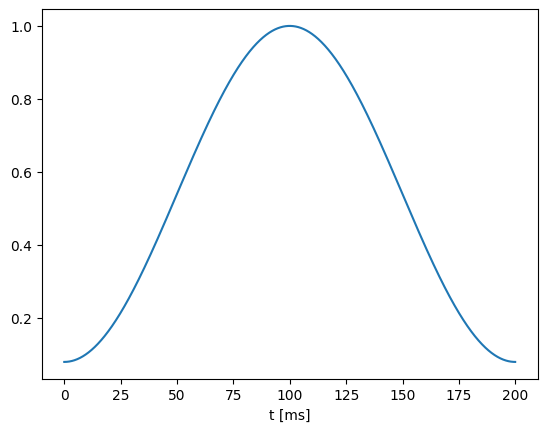

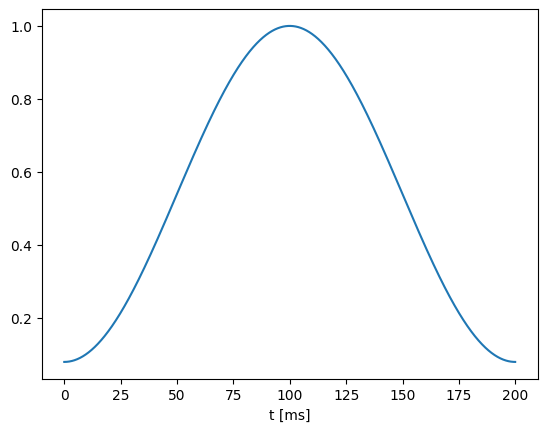

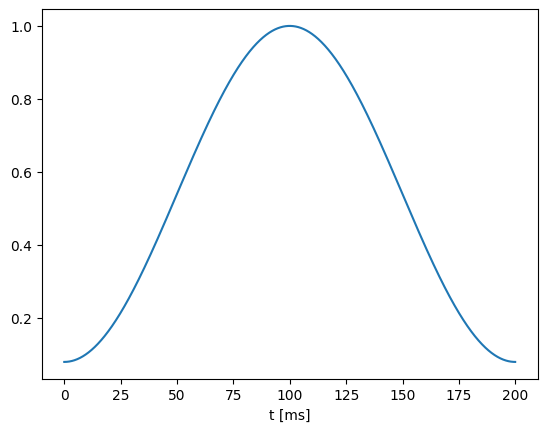

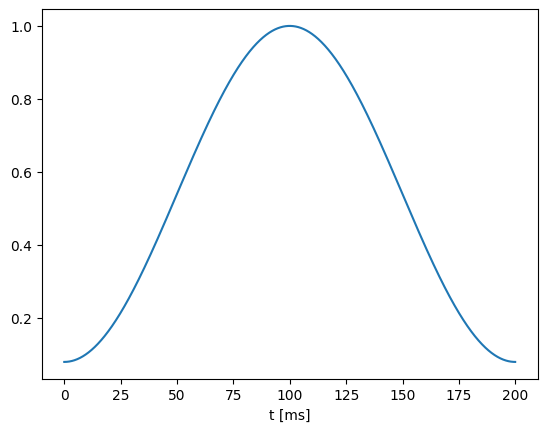

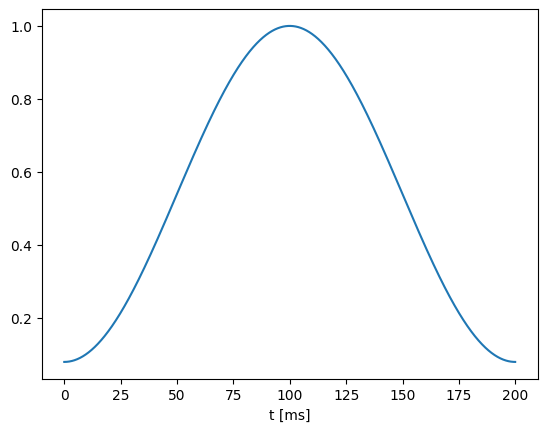

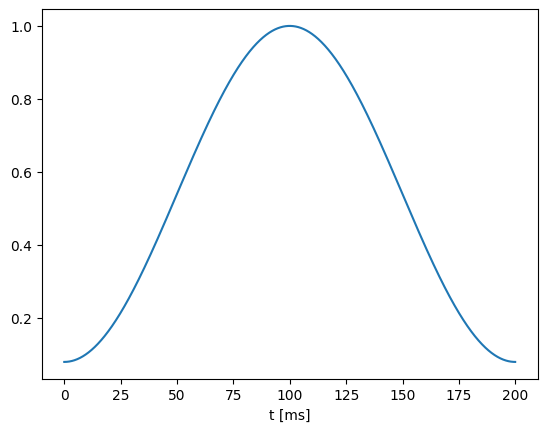

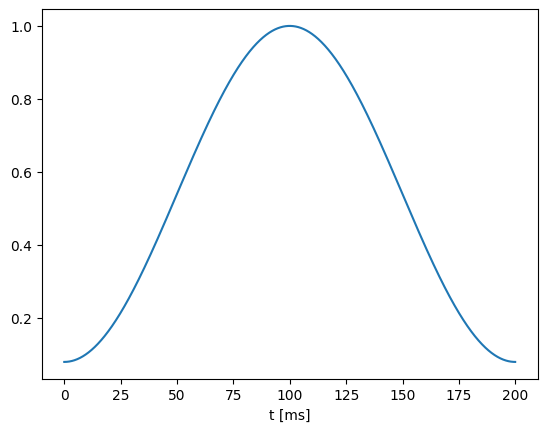

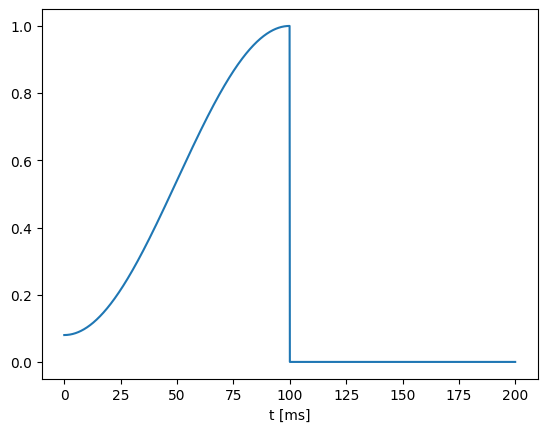

In [16]:
#Exemple de fenêtrage de Hamming d'un signal audio constant
L = 1
size = int(L * fs)
win_dur = 0.2
win = make_window(win_dur, fs)
utils.plot_signal(win, fs)
print(win.shape)
f_init = np.ones( size ,dtype=float )
plt.figure()
utils.plot_signal(f_init, fs)
blocks = blocks_decomposition(f_init, win)
plt.figure()
for i in range(10):
    utils.plot_signal(blocks[i], fs)
plt.show()


Le résultat obtenu est rassurant. La fenêtre dure 200 ms avec un taux de superposition de 50% et obtient exactement 10 blocks. Enfin même plutôt 9.5 ce qui était le nombre auquel on s'attendait théoriquement. 

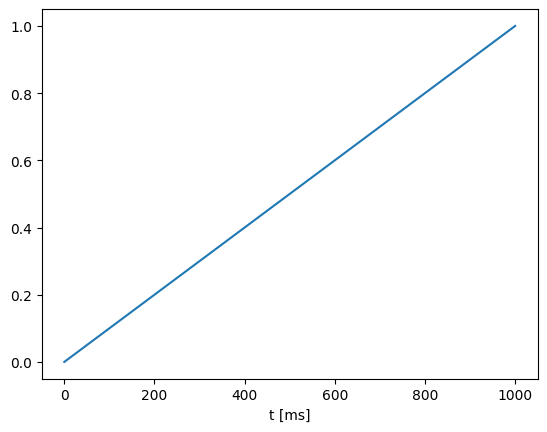

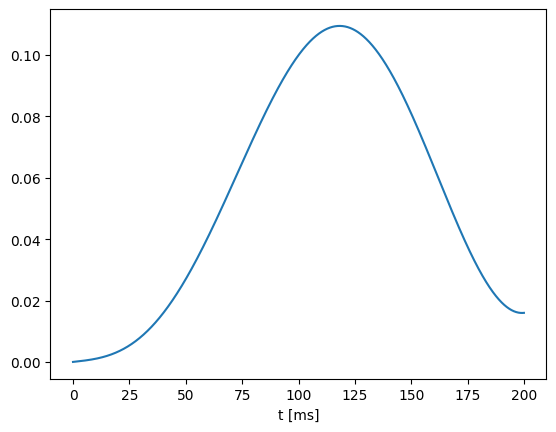

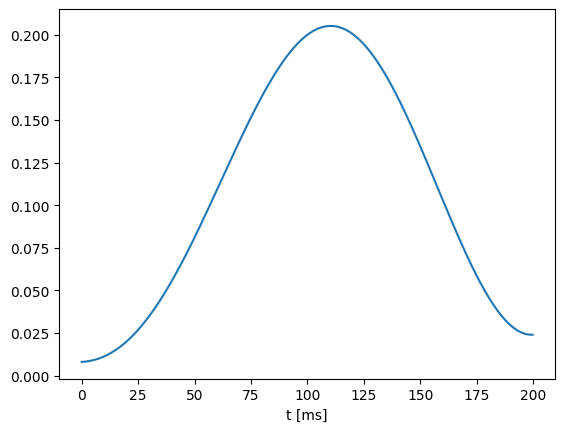

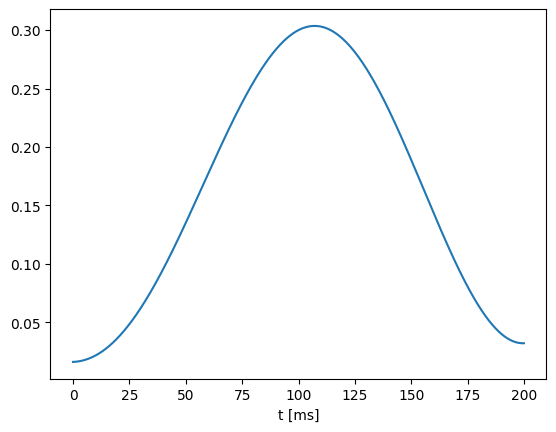

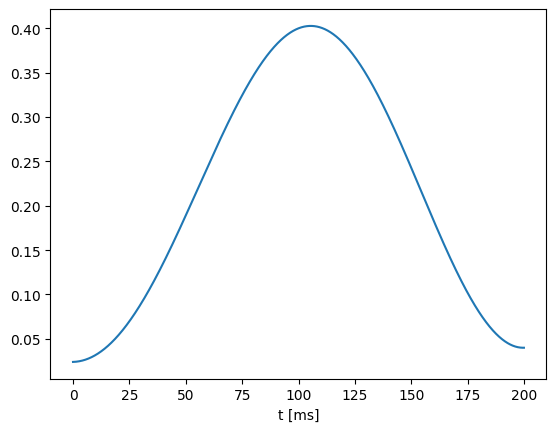

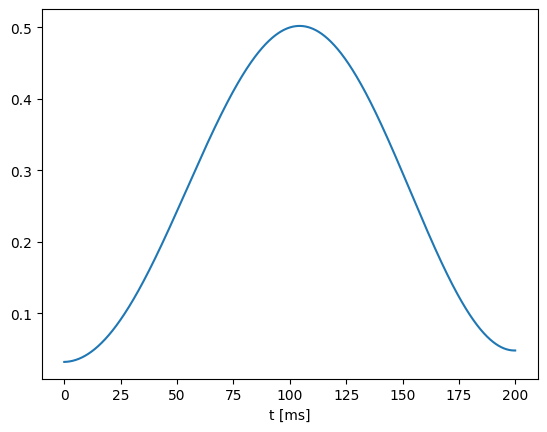

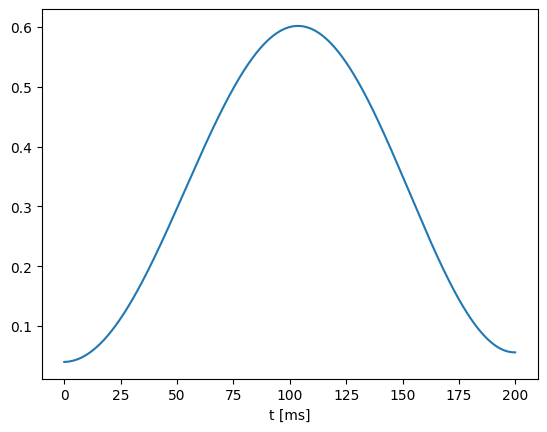

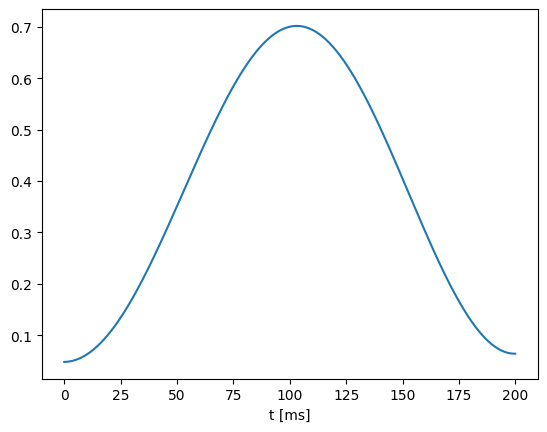

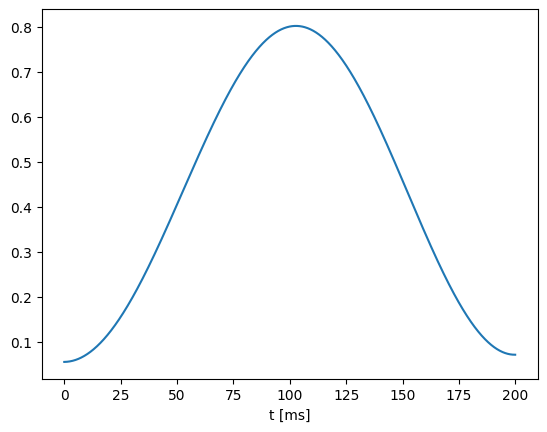

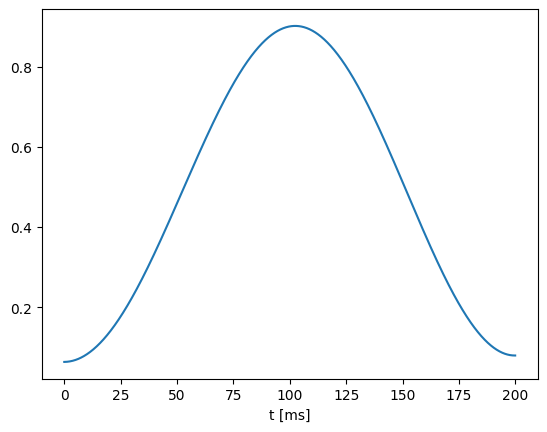

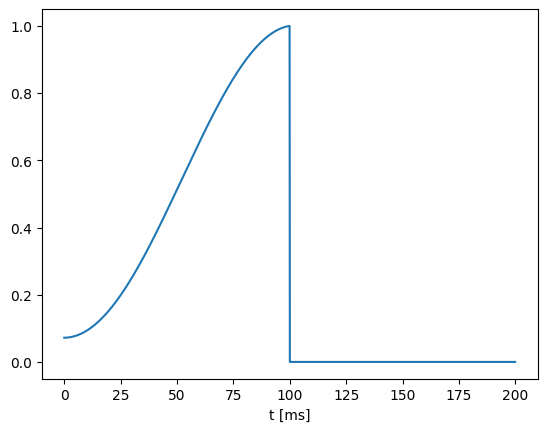

In [17]:
f_init = np.linspace(0, L, size, dtype=float)
plt.figure()
utils.plot_signal(f_init, fs)
blocks = blocks_decomposition(f_init, win)
plt.figure()
for i in range(10):
    utils.plot_signal(blocks[i], fs)
plt.show()


Ici, pour un signal audio de type rampe unitaire, les maximas des différentes parties fenêtrées du signal sont de plus en plus grands ce qui est aussi rassurant et en accord avec ce qui devrait être observé.

Implantons désormais l'opération de reconstruction afin qu'il est possible d'obtenir le signal de départ.

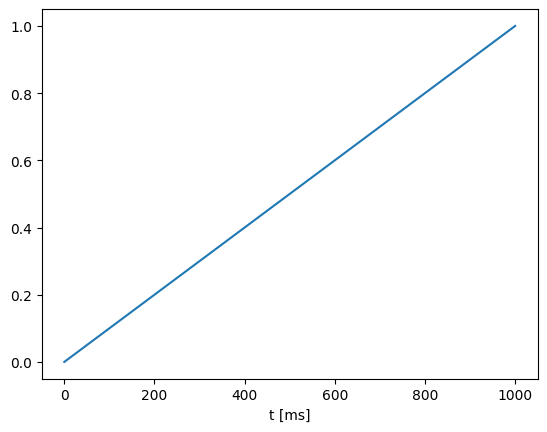

In [18]:
def blocks_reconstruction(blocks, w, signal_size, R=0.5):
    """
    Reconstruct a signal from overlapping blocks

    Parameters
    ----------

    blocks: numpy array
      signal segments. blocks[i,:] contains the i-th windowed
      segment of the speech signal
    w: numpy array
      window
    signal_size: int
      size of the original signal
    R: float (default: 0.5)
      overlapping between subsequent windows

    Return
    ------

    out: numpy array
      reconstructed signal
    """

    interval = int(w.size * R)
    # étendu avec des 0 pour fenêtrer la fin du signal réel
    f_ext = np.zeros(signal_size + w.size, dtype=float)

    for k in range(blocks.shape[0]):
        decoded_block = blocks[k, :] / w
        f_ext[k*interval: k*interval + w.size] += decoded_block
        # utils.plot_signal(f_ext,fs)

    f = f_ext[:signal_size]  # on enlève les 0 ajoutés au bord
    # on moyenne les intervalles d'instants où il y a overlap
    f[interval: blocks.shape[0] * interval] *= 0.5

    return f

f_rec = blocks_reconstruction(blocks, win, f_init.size)
utils.plot_signal(f_rec,fs)

Après reconstruction à partir des blocks on remarque qu'on obtient bien le signal étudié juste au dessus.

## Encodage des segments ##

Commençons par implanter l'estimation des coefficients du filtre pour un segment de parole en codant la fonction `lpc_encode` en utilisant la fonction `solve_toeplitz` de la libraire `scipy` tel que suggéré dans l'énoncé. Implantons deux autres fonctions auxiliaires qui vont être utiles dans la suite du projet : `convolve` qui effectue le produit de convolution entre deux signaux avec un nombre prédéfini de termes ainsi que `autocovariance`.

In [24]:
def autocovariance(x, k):
    """
    Estimates the autocovariance C[k] of signal x

    Parameters
    ----------

    x: numpy array
      speech segment to be encoded
    k: int
      covariance index
    """
    x_acov = np.zeros(x.size - k, dtype=float)
    x_mean = x.mean()
    for u in range(x_acov.size):
        x_acov[u] = (x[u] - x_mean) * (x[u + k] - x_mean)

    return x_acov.mean()


def convolve(a, b, n,p):
    """
    evaluate convolution of a and b in n
    a: numpy array
    b: numpy array
      assumed that b.size >= a.size
    """

    return np.array([a[k] * b[n - 1 - k] for k in range(p)]).sum()


def lpc_encode(x, p):
    """
    Linear predictive coding 

    Predicts the coefficient of the linear filter used to describe the 
    vocal track

    Parameters
    ----------

    x: numpy array
      segment of the speech signal
    p: int
      number of coefficients in the filter
      musts be < x.size ?

    Returns
    -------

    out: tuple (coef, prediction)
      coefs: numpy array
        filter coefficients
      prediction: numpy array
        lpc prediction
    """
    v_acov = np.vectorize(lambda k: autocovariance(x, k))

    alphas = solve_toeplitz(c_or_cr=v_acov(
        np.arange(p)), b=v_acov(np.arange(1, p+1)))

    x_estim = np.zeros(x.size, dtype=float)  # estimations du signal fenêtré
    x_estim[0] = x[0]
    for n in range(1, x.size):
        x_estim[n] = convolve(alphas, x, n,p)

    return alphas, x_estim

Désormais testons cette méthode sur un signal sinusoïdal :

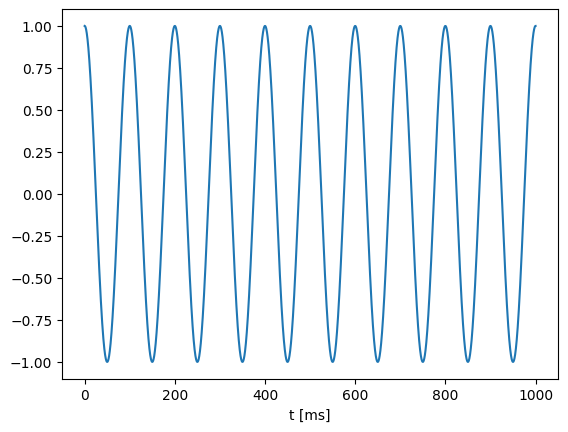

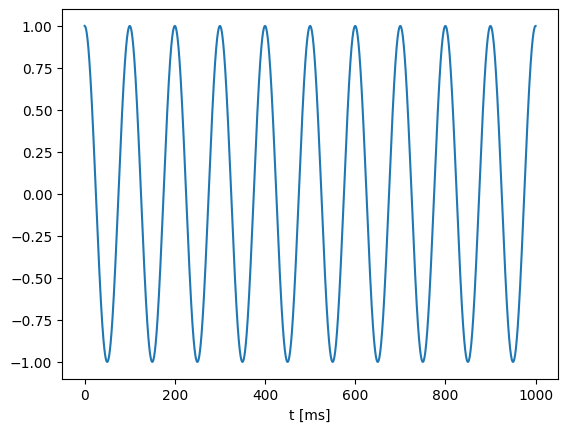

In [28]:
times = np.linspace(0,1,8000)
x = np.cos(2*np.pi * 10 * times)
utils.plot_signal(x, fs)
alphas, x_estim = lpc_encode(x, 32)
utils.plot_signal(x_estim, fs)


Ainsi, on remarque que l'estimation d'un signal sinusoïdal est bien le signal de départ.

In [29]:
def lpc_decode(coefs, source):
    """
    Synthesizes a speech segment using the LPC filter and an excitation source

    Parameters
    ----------

    coefs: numpy array
      filter coefficients

    source: numpy array
      excitation signal

    Returns
    -------

    out: numpy array
      synthesized segment
    """
    s = np.zeros(source.size, dtype=float)
    s[0] = source[0]
    for n in range(1, s.size):
        s[n] = source[n] + convolve(coefs, s,n, len(coefs))
    return s 

## Estimation du pitch

Implantons maintenant la fonction `compute_cepstrum` en utilisant la méthode décrite dans l'énoncé.

In [33]:
def compute_cepstrum(x):
    """
    Computes the cepstrum of the signal

    Parameters
    ----------

    x: numpy array
      signal

    Return
    ------

    out: numpy array
      signal cepstrum
    """

    # abs est vectorisée
    log_norm_dft_s = np.log(abs(np.fft.fft(x)))
    x_cepstrum = np.fft.ifft(log_norm_dft_s)

    return x_cepstrum

def cepstrum_pitch_detection(cepstrum, threshold, max_rate, sample_rate):
    """
    Cepstrum based pitch detection

    Parameters
    ----------

    cepstrum: numpy array
      cepstrum of the signal segment
    threshold: float 
      threshold used to distinguish between voiced/unvoiced segments
    max_rate: float
      maximal pitch frequency
    sample_rate: float
      sample rate of the signal

    Return
    ------

    out: int
      estimated pitch. For an unvoiced segment, the pitch is set to zero
    """
    init_time = 4e-3  # we skip the cepstrum content before this value (in ms)
    init_ind = int(init_time * sample_rate)
    seg_ceps = cepstrum[init_ind:]  # segmented cepstrum

    if np.max(seg_ceps) / np.mean(seg_ceps) > threshold:
        pitch_estim = np.argmax(seg_ceps) / sample_rate
    else:
        pitch_estim = 0.

    return pitch_estim

Testons désormais `compute_cepstrum`sur un signal sinusoïdal :

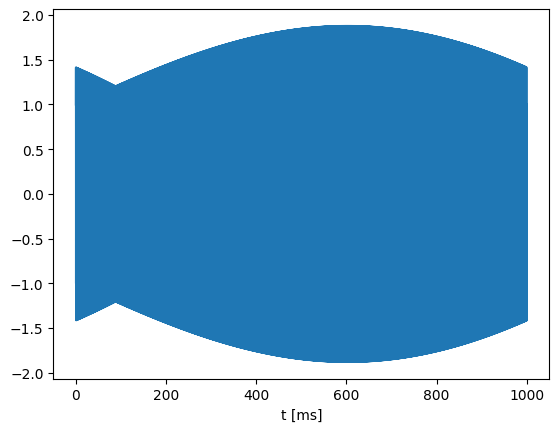

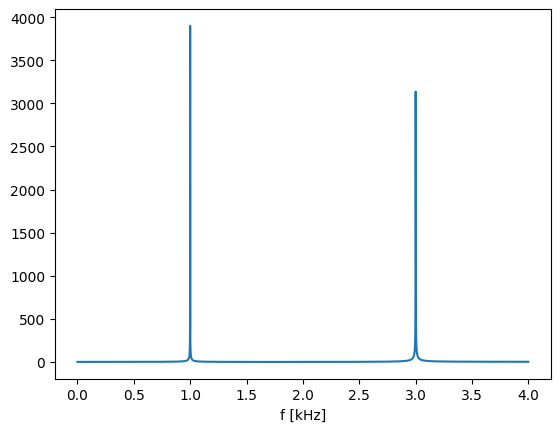

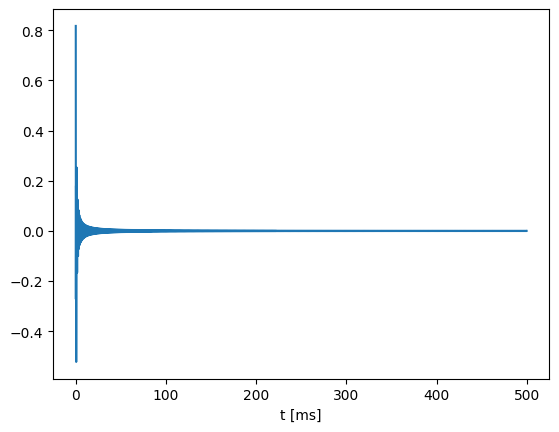

In [32]:
times = np.linspace(0,1,8000)
x = np.cos( 2*np.pi*1e3 * times) + np.sin( 2*np.pi*3e3 * times)
utils.plot_signal(x,fs)
utils.plot_spectrum( np.fft.fft( x ), fs )
utils.plot_cepstrum( compute_cepstrum( x ), fs )

Un autre problème se pose à nous pour le script à étudier. En effet, la théorie mathématique de détection du pitch utilise des peignes de Dirac. Il nous faut donc un moyen d'approximer des diracs de manière assez précise.

In [34]:
def approx_dirac(dir_size:int):
    times = np.linspace(-np.pi, np.pi, dir_size)
    return np.sinc(times)

def create_impulse_train(sample_rate, L: float, T: float) -> np.array:
    """
    create train of M dirac impulsions of duration L sampled at the frequency sample_rate and with a pitch of T (s)
    """
    size = int(L * sample_rate)  # nb of elts in array
    M = int(L / T)
    ind_bet_pitches = int(T * fs)  # nb indices entre 2 émissions de pitch
    e = np.zeros(size, dtype=float)
    for k in range(M):
        e[k * ind_bet_pitches] = 1.

    return e

def create_impulse_train_approx(sample_rate, L: float, T: float, dir_size:int) -> np.array:
    """
    create train of M sinc impulsions of duration L sampled at the frequency sample_rate and with a pitch of T (s)
    - dir_size is the dirac's 'width' in terms of number of array elements
    """
    size = int(L * sample_rate)  # nb of elts in array
    M = int(L / T)
    ind_bet_pitches = int(T * fs)  # nb indices entre 2 émissions de pitch
    e = np.zeros(size, dtype=float)
    for k in range(M):
        start_index = k * ind_bet_pitches # index of beginning of the dirac
        ind_left = size - start_index # nb of elements left
        dir_size_modif = min(ind_left, dir_size) # modified dirac size so it fits in the remaining elements 
        e[ start_index : start_index + dir_size_modif] = approx_dirac(dir_size)[: dir_size_modif]

    return e

Implémentons aussi la version strictement théorique de `compute_cepstrum`.

In [35]:
def compute_cepstrum_dirac_impulse_train_theoric(fs, duration:float, T:float):
    """
    compute theorical cepstrum of impulse train of pitch T
    """ 
    size = int( duration * fs )
    M = int(duration / T)
    ind_bet_pitches = int(T * fs)  # nb indices entre 2 émissions de pitch
    e_cepst = np.zeros(size, dtype=float)
    for k in range(M):
        e_cepst[k * ind_bet_pitches] = 1 / ( k + 1 )

    return e_cepst

Testons notre approximation du peigne de Dirac :

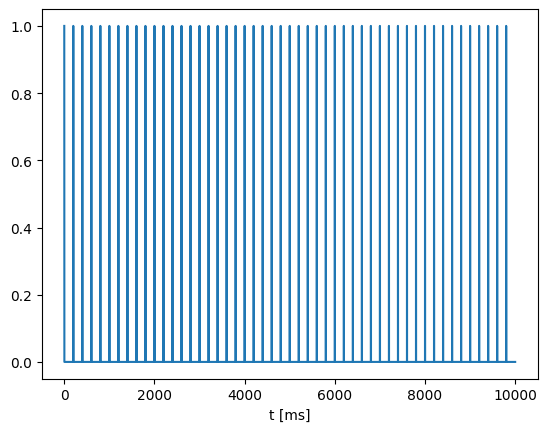

In [37]:
e = create_impulse_train(fs, 10., 0.2)
utils.plot_signal(e, fs)

Testons désormais `compute_cepstrum` :

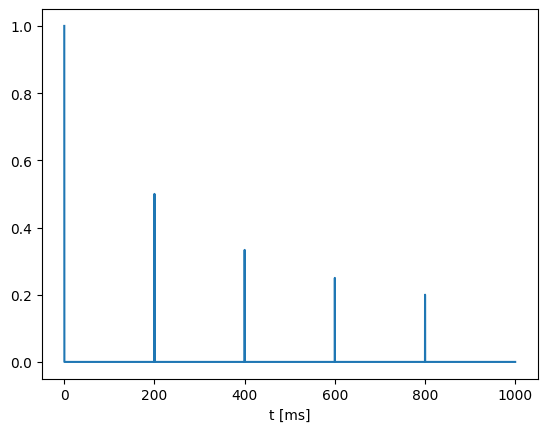

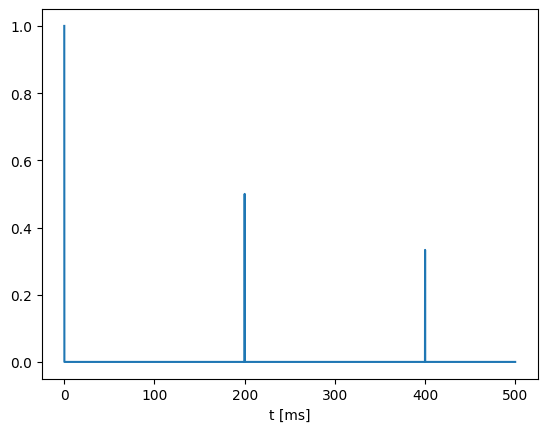

In [60]:
L=1.
T=0.2
e = create_impulse_train(fs, L,T)
e_cepst = compute_cepstrum_dirac_impulse_train_theoric(fs, L,T)
utils.plot_signal(e_cepst, fs)
utils.plot_cepstrum(e_cepst, fs)

On remarque que le résultat avec `compute_cepstrum` correspond à celui attendu après comparaison à la version avec la version "théorique".

Étudions désormais l'algorithme de détection de pitch afin de nous assurer de son bon fonctionnement :

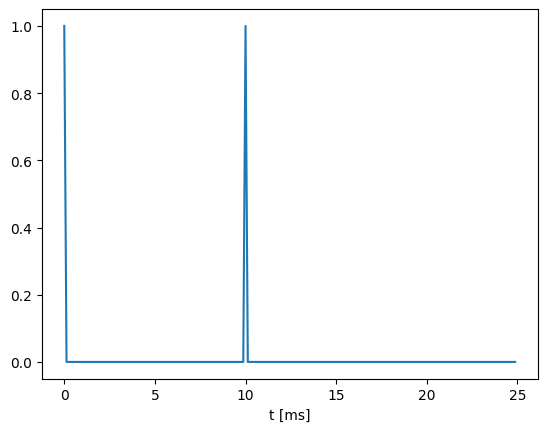

0.01 0.006


In [70]:
size=200
L= size / fs
#T=0.1
T= 0.01
e = create_impulse_train(fs, L, T)
utils.plot_signal(e,fs)
e_cepst_th = compute_cepstrum_dirac_impulse_train_theoric(fs, L , T)
T_found = cepstrum_pitch_detection(e_cepst_th, 0.0, 1000, fs)
print(T, T_found)

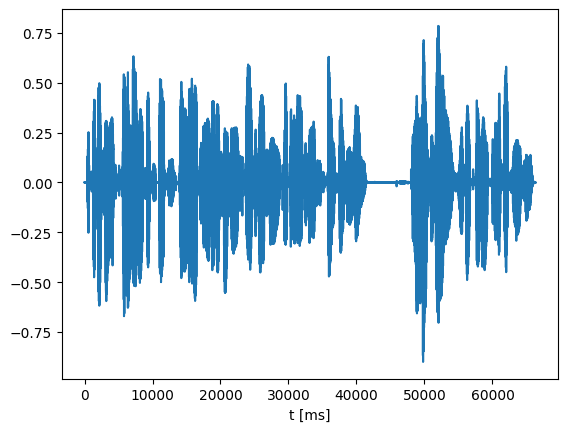

/var/folders/74/bcmygj1n3yj3djmv4kgqrkch0000gp/T/ipykernel_23721/396405262.py:30: RuntimeWarning: invalid value encountered in divide
  decoded_block = blocks[k, :] / w


In [58]:
"""
LPC encoding
"""

if __name__ == '__main__':


    [sample_rate, speech] = wavfile.read('/Users/rachid.outbib/Desktop/Mines/1A/S2/Traitement du SIgnal/TDS-projet-signaux-parole-main/audio/speech.wav')
    speech = np.array(speech)

    # tests sur un segment seulement
    #speech = np.array(speech)[200*160: 300*160]

    # normalize the speech
    speech = 0.9*speech/max(abs(speech))

    utils.plot_signal(speech, fs)

    # resampling to 8kHz
    target_sample_rate = 8000
    target_size = int(len(speech)*target_sample_rate/sample_rate)
    speech = resample(speech, target_size)
    sample_rate = target_sample_rate
    
    # Record resampled signal
    wavfile.write("speech_resampled.wav", sample_rate, speech)

    #  window
    w = hann(floor(0.005*sample_rate), False)

    # test OK
    # utils.plot_signal(w, sample_rate)
    
    # Block decomposition
    blocks = blocks_decomposition(speech, w, R = 0.5)
    n_blocks, block_size = blocks.shape
    
    # --------------------
    # Encoding
    # --------------------
    
    p = 32 # LPC filter: number of coefficients
    threshold = 0.8 # Parameters for pitch detection
    max_rate = 200 # Maximal pitch frequency [Hz]
        
    lpc_coefs, pitches, gain, errors = [], [], [], []
    for block in blocks:

        # Linear predictive coding
        coefs, prediction = lpc_encode(block, p)
        
        # test précision prédiction OK
        # plt.title('block + prediction')
        # utils.plot_signal(block, sample_rate)
        # utils.plot_signal(prediction, sample_rate)

        error = block - prediction
        
        # Pitch detection
        cepstrum = compute_cepstrum(block)

        # test cepstres OK
        # plt.title("cepstres")
        # plot_cepstrum(cepstrum, sample_rate)

        pitch = cepstrum_pitch_detection(cepstrum, threshold, max_rate, 
         sample_rate)
        
        # Update
        lpc_coefs.append(coefs)
        pitches.append(pitch)
        gain.append(np.std(error))
        errors.append(error)
        
    # --------------------
    # Decoding
    # --------------------
    
    blocks_decoded = []
    for coefs, pitch, g in zip(lpc_coefs, pitches, gain):
    
        # Creates an excitation signal for a non-voiced speech
        noise = g*np.random.randn(block_size)

        if(pitch != 0.):
        
            # create an excitation signal based upon a train of
            # impulses of the same length as the current block
            #source = g * create_impulse_train(sample_rate, block_size / sample_rate, pitch)

            # test source NOT OK seulement 1 pic au début de chaque source
            #plt.title('source')
            #utils.plot_signal(source, sample_rate)

            # version modifiée dirac approximé
            source = g * create_impulse_train_approx(sample_rate, block_size / sample_rate, pitch, 50)

            # test source dirac
            # plt.title('source modifiée')
            # utils.plot_signal(source, sample_rate)
            
            
        else:
            source = noise
    
        block_decoded = lpc_decode(coefs, w*source)

        # test décodage NOT OK AT ALL
        # plt.title('block')
        # utils.plot_signal(block, sample_rate)
        # plt.title('decoded_block')
        # utils.plot_signal(block_decoded, sample_rate)

        blocks_decoded.append(block_decoded) # problème ici
        
    blocks_decoded = np.array(blocks_decoded) 
    decoded_speech = blocks_reconstruction(blocks_decoded, w, speech.size, 
      R = 0.5)
    # utils.plot_signal(decoded_speech, sample_rate)
    
    np.nan_to_num(decoded_speech, copy=False, posinf=0., neginf=0.) # effacement des Nan
    
    wavfile.write("decoded_speech.wav", sample_rate, decoded_speech)